#                 Методы современной прикладной статистики


##          Cеминар 8. Отбор признаков.


###                                                12 апреля 2018г.

In [82]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [390]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from scipy.stats import pearsonr, t

from itertools import chain, combinations
from tqdm import tqdm

import copy

Данные, с которыми будем работать дальше

In [3]:
data = load_boston()
X, y = data.data, data.target

#X - информация о домах
#y - стоимость домов

indices = np.random.shuffle(np.arange(len(y)))
X = X[indices, :]
y = y[indices]

Сразу пронормируем данные

In [273]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Взглянем на данные

In [7]:
y[:3]

array([32.7, 23. , 21.9])

In [10]:
y.shape

(506,)

In [86]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.01301,35.0,1.52,0.0,0.442,7.241,49.3,7.0379,1.0,284.0,15.5,394.74,5.49
1,0.30347,0.0,7.38,0.0,0.493,6.312,28.9,5.4159,5.0,287.0,19.6,396.90,6.15
2,0.04819,80.0,3.64,0.0,0.392,6.108,32.0,9.2203,1.0,315.0,16.4,392.89,6.57
3,0.19073,22.0,5.86,0.0,0.431,6.718,17.5,7.8265,7.0,330.0,19.1,393.74,6.56
4,0.21161,0.0,8.56,0.0,0.520,6.137,87.4,2.7147,5.0,384.0,20.9,394.47,13.44


In [274]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,2.808469e-17,1.053176e-17,-1.283119e-15,-7.021173e-18,-6.935164e-15,-1.022634e-14,-1.825505e-16,-5.336092e-16,1.667529e-17,-3.510587e-18,7.793502e-15,1.047208e-14,-8.284984e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.177134e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-3.907193e+00,-1.531127e+00
25%,-4.088961e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,2.050715e-01,-7.994200e-01
50%,-3.885818e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,3.811865e-01,-1.812536e-01
75%,6.248255e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,4.336510e-01,6.030188e-01
max,9.941735e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,4.410519e-01,3.548771e+00


In [9]:
X.shape

(506, 13)

In [12]:
k = X.shape[1]
n = X.shape[0]

## Полный перебор возможных наборов признаков

In [275]:
def calc_AIC(y_true, y_pred, k):
    n = len(y_true)
    return 2.0 * k + n * (np.log(np.mean((y_true - y_pred) ** 2)) + 1.0)

In [276]:
def mask_to_list(mask, k):
    bits = np.array([(mask >> i) % 2 for i in range(k)], dtype=bool)
    return np.arange(k)[bits]

In [335]:
fullsearch_adj_r2_score = dict()
fullsearch_AIC = dict()
fullsearch_cv_score = dict()

for mask in tqdm(np.arange(1, 2 ** k)):
    features = mask_to_list(mask, k)
    
    reg = LinearRegression()
    reg.fit(X[:, features], y)
    y_pred = reg.predict(X[:, features])
    
    fullsearch_adj_r2_score[mask] = 1.0 - (1.0 - r2_score(y, y_pred)) * (n - 1.0) / (n - len(features) - 1.0)
    fullsearch_AIC[mask] = calc_AIC(y, y_pred, len(features))
    fullsearch_cv_score[mask] = cross_val_score(reg, X[:, features], y, scoring='neg_mean_squared_error', cv=5).mean()
    
    #cross_val_score

100%|██████████| 8191/8191 [01:28<00:00, 93.07it/s] 


Лучшая конфигурация по $R^2$

In [278]:
best_adj_r2_mask = fullsearch_adj_r2_score.keys()[np.argmax(fullsearch_adj_r2_score.values())]
best_adj_r2_score = fullsearch_adj_r2_score[best_adj_r2_mask]

In [279]:
print mask_to_list(best_adj_r2_mask, k)
print best_adj_r2_score

[ 0  1  3  4  5  7  8  9 10 11 12]
0.7347680218285483


Лучшая конфигурация по AIC

In [280]:
best_AIC_mask = fullsearch_AIC.keys()[np.argmax(fullsearch_AIC.values())]
best_AIC = fullsearch_AIC[best_AIC_mask]

In [281]:
print mask_to_list(best_AIC_mask, k)

[3]


In [282]:
best_AIC

2089.8326163876677

Лучшая конфигурация по 5-fold кросс-валидации

In [336]:
best_cv_mask = fullsearch_cv_score.keys()[np.argmax(fullsearch_cv_score.values())]
best_cv_score = fullsearch_cv_score[best_cv_mask]

In [339]:
print mask_to_list(best_cv_mask, k)
print best_cv_score

[ 0  1  3  4  5  7  8  9 10 11 12]
-23.263109100116242


## Простые методы отбора признаков

### Критерий Стьюдента

In [283]:
def calc_student_intervals(X, y, alpha=0.05):
    k = X.shape[1]
    n = X.shape[0]
    
    X = np.matrix(X)
    
    Z = np.linalg.inv(X.T * X)
    beta = np.array(Z * X.T * np.matrix(y).T).reshape(-1)
    return zip(beta - t.ppf(1.0 - alpha / 2.0, n - k - 1) * np.sqrt(np.diag(Z)),
               beta + t.ppf(1.0 - alpha / 2.0, n - k - 1) * np.sqrt(np.diag(Z)))

In [284]:
student_intervals = calc_student_intervals(X, y, 0.05)

In [285]:
student_intervals

[(-1.036726242182215, -0.8040960132180903),
 (0.9485531052498967, 1.2134080510910898),
 (-0.03153228100621461, 0.31746652904646533),
 (0.5916858589946936, 0.7727210615734164),
 (-2.2432079615375327, -1.8769769655448225),
 (2.5491658783682007, 2.792116948280806),
 (-0.13268901288710566, 0.17493027413006157),
 (-3.278188473689465, -2.930707629278982),
 (2.41989049686484, 2.897682584948987),
 (-2.338059136268433, -1.813737145592),
 (-2.179317359281021, -1.9449944926662637),
 (0.755310456571258, 0.9579704150627663),
 (-3.8983991171597068, -3.598960521079704)]

In [286]:
[_ for _, interval in enumerate(student_intervals) if 0.0 < interval[0] or 0.0 > interval[1]]

[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12]

По критерию Стьюдента отбрасываются признаки 2 и 6

Посмотрим, что будет, если оставлять признаки с наименьшими p-value

In [313]:
def get_student_selection_scores(reg, X, y):
    k = X.shape[1]
    student_intervals = calc_student_intervals(X, y)
    values = np.abs([(high + low) / (high - low) for low, high in student_intervals])
    
    abs_correlations = np.abs([pearsonr(X[:, i], y)[0] for i in xrange(k)])
    
    scores = list()
    for features_count in xrange(1, k + 1):
        X_sub = X[:, np.argsort(-values)[: features_count]]
        
        scores.append(
            cross_val_score(reg, X_sub, y, scoring='neg_mean_squared_error', cv=5).mean()
        )
        
    return scores

In [314]:
student_selection_scores = get_student_selection_scores(LinearRegression(), X, y)

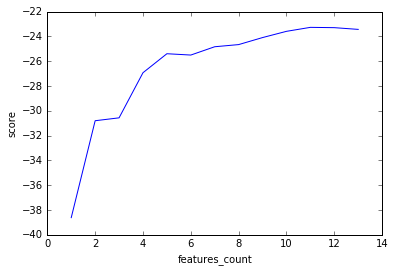

In [320]:
plt.plot(range(1, k + 1), student_selection_scores)
plt.xlabel("features_count")
plt.ylabel("score")

### Корреляции признаков с таргетом


<Container object of 13 artists>

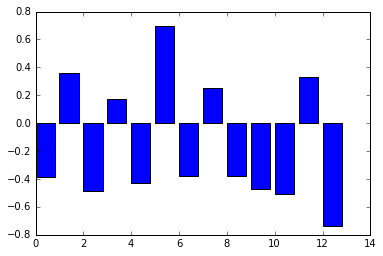

In [287]:
plt.bar(np.arange(k), [pearsonr(X[:, i], y)[0] for i in xrange(k)])

In [304]:
np.argsort(-np.abs([pearsonr(X[:, i], y)[0] for i in xrange(k)]))

array([12,  5, 10,  2,  9,  4,  0,  8,  6,  1, 11,  7,  3])

Взглянем на значения p-value

In [299]:
print [pearsonr(X[:, i], y)[1] for i in xrange(k)]

[2.0835501108141935e-19, 5.713584153081686e-17, 4.900259981753171e-31, 7.390623170520815e-05, 7.065041586254333e-24, 2.487228871007871e-74, 1.5699822091882311e-18, 1.206611727337284e-08, 5.465932569648955e-19, 5.637733627691498e-29, 1.6095094784729786e-34, 1.318112734075642e-14, 5.081103394388712e-88]


Этим методом не получилось явно отбросить ни одного признака. Посмотрим, что будет, если будем оставлять самые коррелированные с таргетом признаки

In [316]:
def get_simple_corr_selection_scores(reg, X, y):
    k = X.shape[1]
    abs_correlations = np.abs([pearsonr(X[:, i], y)[0] for i in xrange(k)])
    
    scores = list()
    for features_count in xrange(1, k + 1):
        X_sub = X[:, np.argsort(-abs_correlations)[: features_count]]
        
        scores.append(
            cross_val_score(reg, X_sub, y, scoring='neg_mean_squared_error', cv=5).mean()
        )
        
    return scores

In [317]:
simple_corr_selection_scores = get_simple_corr_selection_scores(LinearRegression(), X, y)

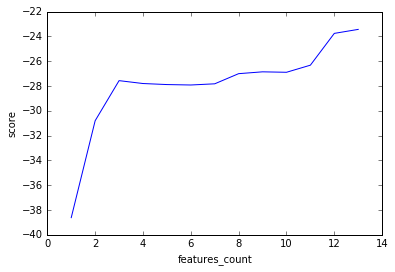

In [319]:
plt.plot(range(1, k + 1), simple_corr_selection_scores)
plt.xlabel("features_count")
plt.ylabel("score")

In [366]:
res = get_simple_corr_selection_scores(RandomForestRegressor(n_estimators=100), X, y)

In [ ]:
plt.plot(res)

## Методы посложнее

### Рекурсивный отбор признаков с ExtraTreesRegressor

In [288]:
forest = ExtraTreesRegressor(n_estimators=100)

In [289]:
forest.fit(X, y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [291]:
forest.feature_importances_

array([0.03000337, 0.00350329, 0.04515324, 0.01485431, 0.0374417 ,
       0.32084764, 0.01680223, 0.0330382 , 0.01848408, 0.04994605,
       0.04721763, 0.01874301, 0.36396524])

In [290]:
np.argsort(-forest.feature_importances_)

array([12,  5,  9, 10,  2,  4,  7,  0, 11,  8,  6,  3,  1])

Выбираем алгоритм (estimator), применяем его, и он в результате своей работы присваивает веса всем признакам. Затем откидываем наименее важные признаки и снова запускаем estimator и т.д., до тех пор, пока не останется заранее заданное число признаков.

In [324]:
def get_rfe_extra_trees_scores(reg, X, y):
    k = X.shape[1]
    
    scores = list()
    for features_count in range(1, k + 1):
        X_rfe = RFE(
            estimator=ExtraTreesRegressor(n_estimators=100),
            n_features_to_select=features_count, step=1
        ).fit_transform(X, y)
        
        scores.append(
            cross_val_score(reg, X_rfe, y, scoring='neg_mean_squared_error', cv=5).mean()
        )
        
    return scores
    

In [325]:
rfe_extra_trees_scores = get_rfe_extra_trees_scores(LinearRegression(), X, y)

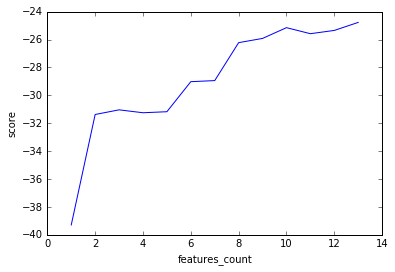

In [321]:
plt.plot(range(1, k + 1), rfe_extra_trees_scores)
plt.xlabel("features_count")
plt.ylabel("score")

### Линейная регрессия с L1 регуляризацией

При добавлении l1 регуляризатора в функцию потерь часть коэффициентов в линейной регрессии зануляется, что дает еще один метод отбора признаков, который можно регулировать с помощью коэффициента регуляризации.

$$\frac{1}{2n} ||y - Xw||^2_2 + \alpha ||w||_1$$

In [396]:
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [397]:
lasso_reg.coef_

array([-0.        ,  0.        , -0.        ,  0.        , -0.        ,
        2.71335334, -0.        , -0.        , -0.        , -0.        ,
       -1.3435484 ,  0.18095537, -3.54338288])

### Пошаговая регрессия

In [218]:
from scipy.stats import f

In [360]:
def dict_max_key(d):
    return d.keys()[np.argmax(d.values())]

def dict_min_key(d):
    return d.keys()[np.argmin(d.values())]

def RSS(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def stepwise_regression_selection(X, y, p_in=0.05, p_out=0.1):
    n = X.shape[0]
    k = X.shape[1]
    
    def calc_pred(features):
        reg = LinearRegression()
        reg.fit(X[:, features], y)
        return reg.predict(X[:, features])
        
    #initialize 
    feature_scores = dict()
    for feature in range(k):
        y_pred = calc_pred([feature])
        
        left, right = calc_student_intervals(X[:, [feature]], y)[0]
        feature_scores[feature] = np.abs((left + right) / (right - left))
        
    current_features = [dict_max_key(feature_scores)]
    cur_rss = RSS(y, calc_pred(current_features))

    while True:
        features_backup = copy.deepcopy(current_features)
        
        # add
        feature_scores = dict()
        for feature in set(range(k)) - set(current_features):
            y_pred = calc_pred(current_features + [feature])
            
            new_rss = RSS(y, y_pred)
            feature_scores[feature] = 1.0 - f.cdf((cur_rss - new_rss) * (n - len(current_features) - 2.0) / new_rss, 
                                                  n - len(current_features) - 2.0, 1)
            
        candidate_feature = dict_min_key(feature_scores)
        if feature_scores[candidate_feature] < p_in:
            current_features.append(candidate_feature)
            cur_rss = RSS(y, calc_pred(current_features))
            
        # remove
        if len(current_features) == 1:
            break
        feature_scores = dict()
        for feature in current_features:
            new_features = copy.deepcopy(current_features)
            new_features.remove(feature)
            y_pred = calc_pred(new_features)
            
            new_rss = RSS(y, y_pred)
            feature_scores[feature] = 1.0 - f.cdf((new_rss - cur_rss) * (n - len(current_features) - 1.0) / cur_rss, 
                                                   n - len(current_features) - 1.0, 1)
            
        candidate_feature = dict_max_key(feature_scores)
        if feature_scores[candidate_feature] > p_out:
            current_features.remove(candidate_feature)
            cur_rss = RSS(y, calc_pred(current_features))
               
        if set(features_backup) == set(current_features):
            break
            
    return current_features

In [363]:
selected_features = stepwise_regression_selection(X, y, p_in=0.2, p_out=0.2)

In [364]:
print selected_features

[12, 5, 10, 7, 4]


Можно посмотреть на результат отбора при разных порогах $p_{in}$ и $p_{out}$

### Может быть, стоило произвести какие-то преобразования признаков?

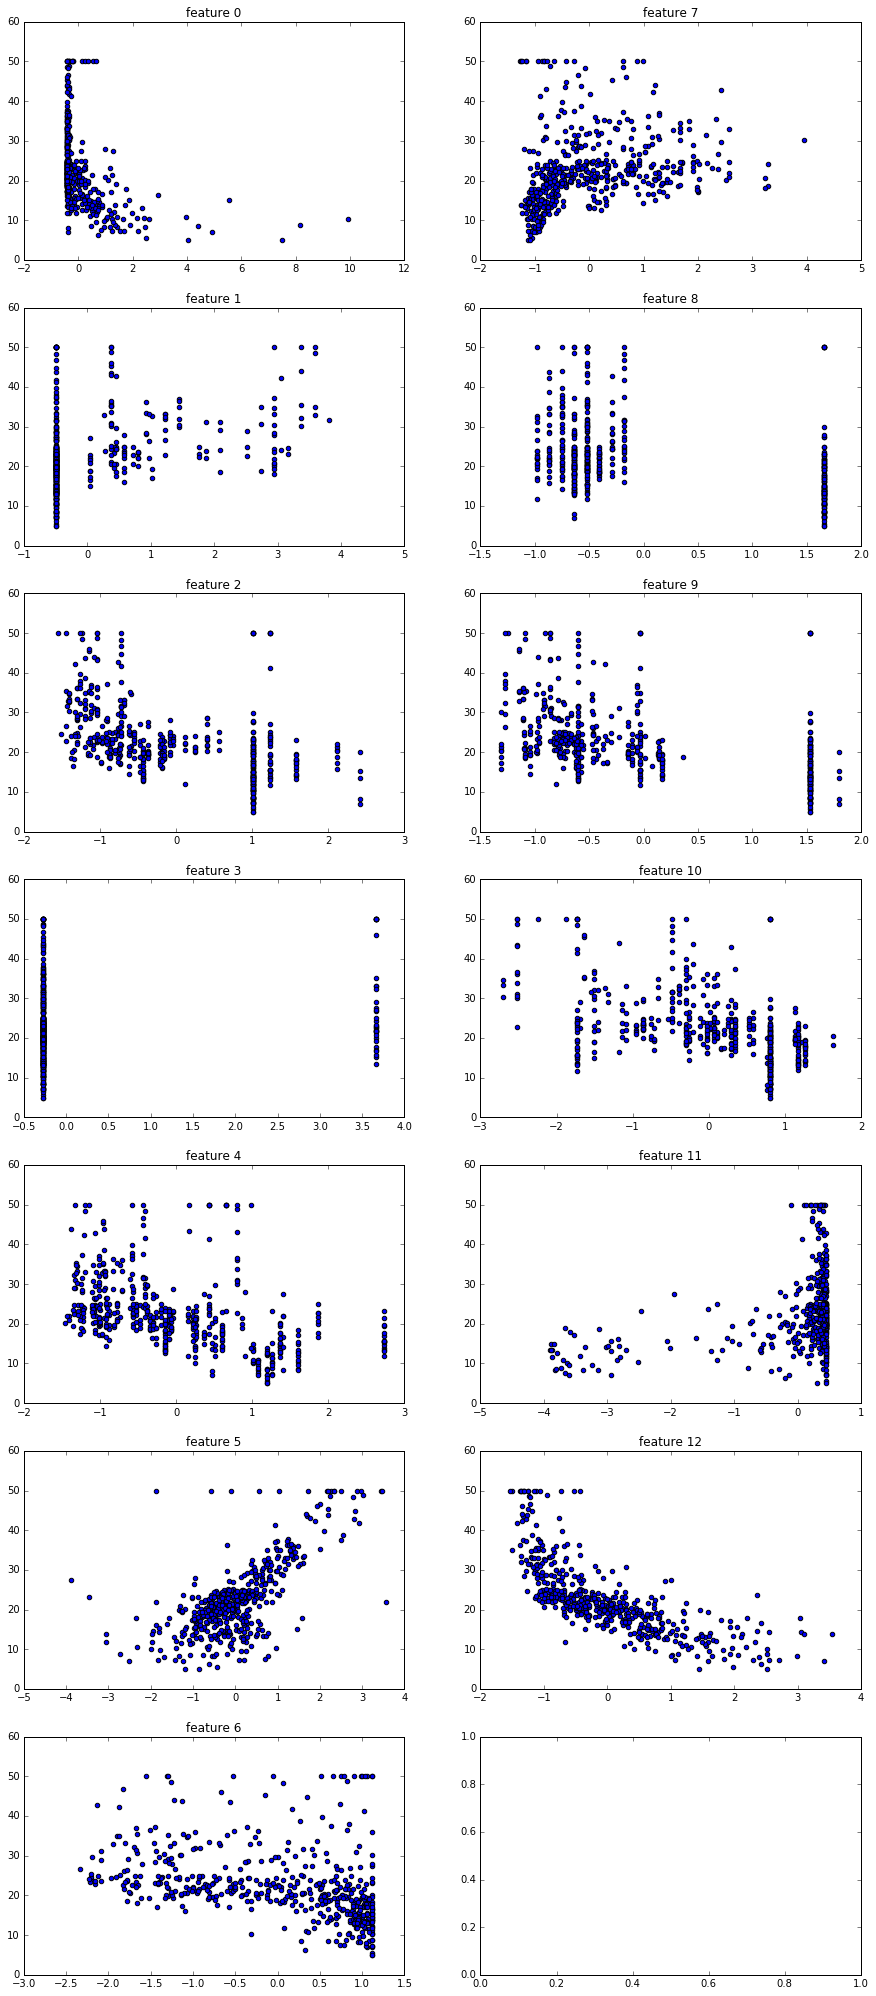

In [388]:
f, axes = plt.subplots(7, 2, figsize = (15, 35))
for feature in range(k):
    sys.stdout.flush()
    axes[feature % 7, feature // 7].scatter(X[:, feature], y)
    axes[feature % 7, feature // 7].set_title("feature %s" % feature)
plt.show()

Кажется, что отдельного преобразования "заслуживает" лишь переменная №12

In [ ]:
#X[:, 12] = 1.0 / X[:, 12]

Проделаем некоторые процедуры, описанные выше, с преобразованными признаками